<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/CNN_Anomaly__Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras 
from tensorflow.keras import layers
from matplotlib import pyplot as plt
print(keras.__version__)

2.4.0


In [2]:
df=pd.read_csv('/content/ευδαπ_dataset_527085.csv')
print(df)

   timestamp  indication  delta  linear(20)
0   27-01-01         395    NaN         395
1   24-04-01         396    1.0         415
2   26-07-01         396    0.0         435
3   22-10-01         396    0.0         455
4   25-01-02         396    0.0         475
..       ...         ...    ...         ...
76  14-10-19           0    0.0        1915
77  17-10-19           2    2.0        1935
78  30-01-20          24   22.0        1955
79  05-05-20          45   21.0        1975
80  26-07-20          62   17.0        1995

[81 rows x 4 columns]


In [3]:
from IPython.display import display, Markdown
def report(df):
    display(Markdown('<b>head():</b>'))
    display(df.head())
    display(Markdown('<b>describe():</b>'))
    display(df.describe())
    display(Markdown('<b>info():</b>'))
    display(df.info(verbose=True))
    display(Markdown('<b>infer_dtype():</b>'))
    display(df.apply(lambda x: pd.api.types.infer_dtype(x.values)))
report(df)

<b>head():</b>

,timestamp,indication,delta,linear(20)
0,27-01-01,395,NaN,395
1,24-04-01,396,1.0,415
2,26-07-01,396,0.0,435
3,22-10-01,396,0.0,455
4,25-01-02,396,0.0,475


<b>describe():</b>

,indication,delta,linear(20)
count,81.000000,80.000000,81.000000
mean,432.641975,-4.162500,1195.000000
std,160.258097,80.014151,470.531614
min,0.000000,-566.000000,395.000000
25%,399.000000,0.000000,795.000000
50%,470.000000,1.000000,1195.000000
75%,565.000000,6.000000,1595.000000
max,566.000000,89.000000,1995.000000


<b>info():</b>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   81 non-null     object 
 1   indication  81 non-null     int64  
 2   delta       80 non-null     float64
 3   linear(20)  81 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ KB


None

<b>infer_dtype():</b>

timestamp       string
indication     integer
delta         floating
linear(20)     integer
dtype: object

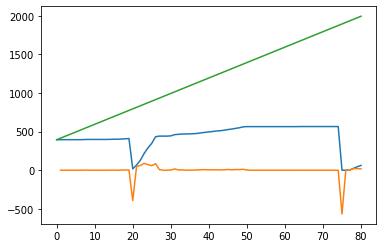

In [4]:
fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()

# Prepare training data

In [5]:
# Normalize and save the mean and std we get,
# for normalizing test data.
df1=df.loc[:,['linear(20)']]
training_mean = df1.mean()
training_std = df1.std()
df_training_value = (df1 - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
print("Number of training samples:", df_training_value.shape)

Number of training samples: 81
Number of training samples: (81, 1)


In [6]:
TIME_STEPS = 8

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (73, 8, 1)


# Build a model

In [7]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 32)             256       
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 16)             3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 4, 16)             1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 16)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 8, 32)             3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 8, 1)              2

In [8]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=8,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, mode="min")
    ],
)

Epoch 1/50
9/9 [==============================] - 2s 56ms/step - loss: 0.5938 - val_loss: 1.8444
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 0.6353 - val_loss: 1.6597
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.3263 - val_loss: 1.2505
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 0.1592 - val_loss: 0.4633
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0650 - val_loss: 0.1403
Epoch 6/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0805 - val_loss: 0.0997
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0462 - val_loss: 0.1102
Epoch 8/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0345 - val_loss: 0.0273
Epoch 9/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0323 - val_loss: 0.0317
Epoch 10/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0314 - val_loss: 0.0148
Epoch 11/50
9/9 [=====================

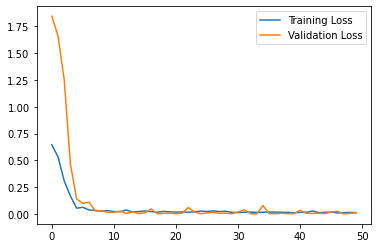

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Detecting anomalies

detect anomalies by determining how well our model can reconstruct the input data.

Find MAE loss on training samples.
Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

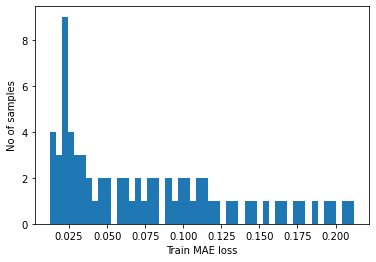

Reconstruction error threshold:  0.2122352032050617


In [10]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

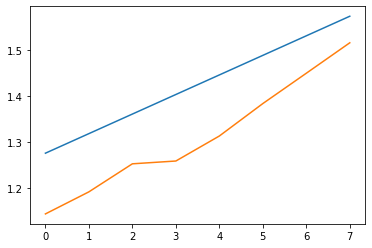

In [32]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

# **Prepare test data**

In [12]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

df2=df[['indication']]
training_mean = df2.mean()
training_std = df2.std()

df_test_value = (df2 - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
print("Number of training samples:", df_training_value.shape)


Number of training samples: 81
Number of training samples: (81, 1)


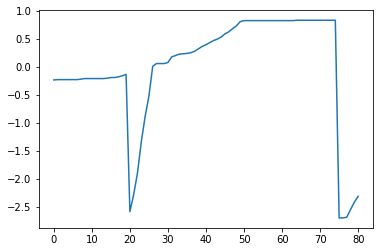

In [13]:
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [14]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (73, 8, 1)


In [15]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

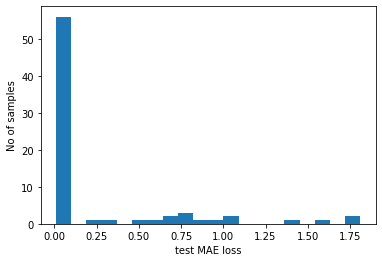

In [27]:
plt.hist(test_mae_loss, bins=20)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()



In [28]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  16
Indices of anomaly samples:  (array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 68, 69, 70, 71, 72]),)


# Plot anomalies

We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. We will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.

In [29]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

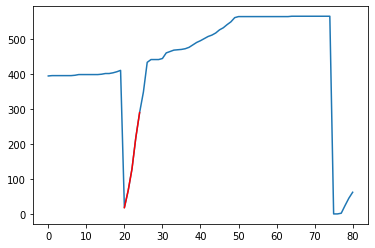

In [20]:
df_subset = df2.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df2.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()